<a href="https://colab.research.google.com/github/SAGARGS4/bike-sharing-demand-analysis/blob/main/Bikeshareing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

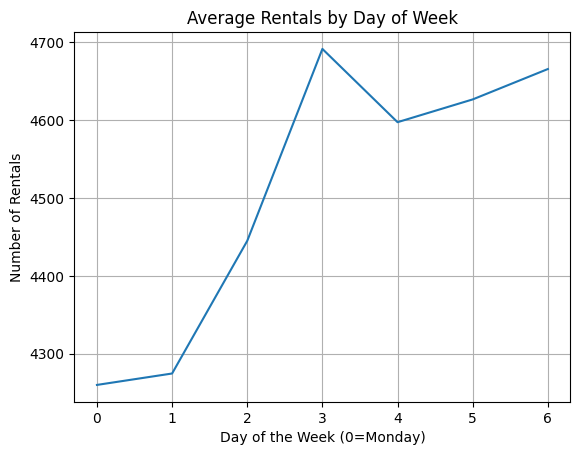

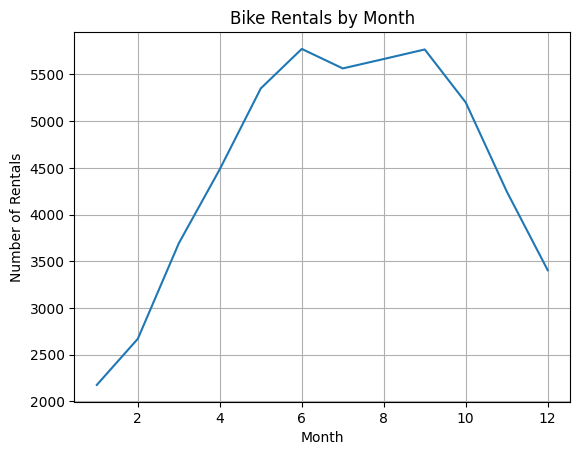

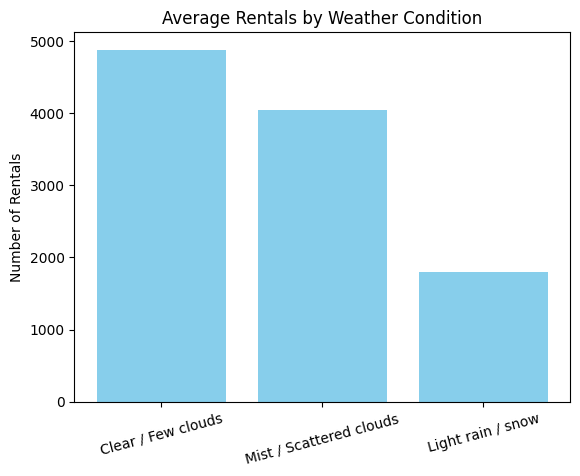

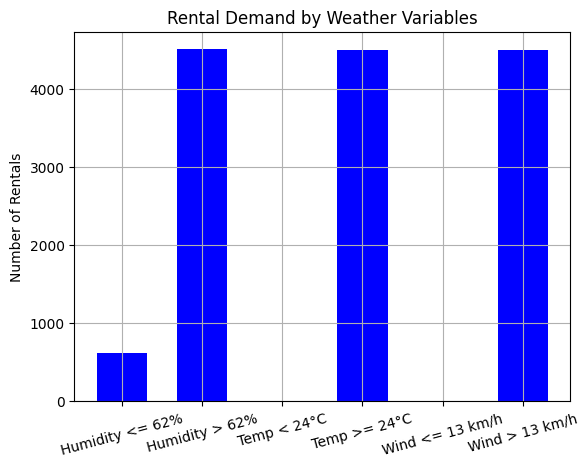

<Figure size 1000x800 with 0 Axes>

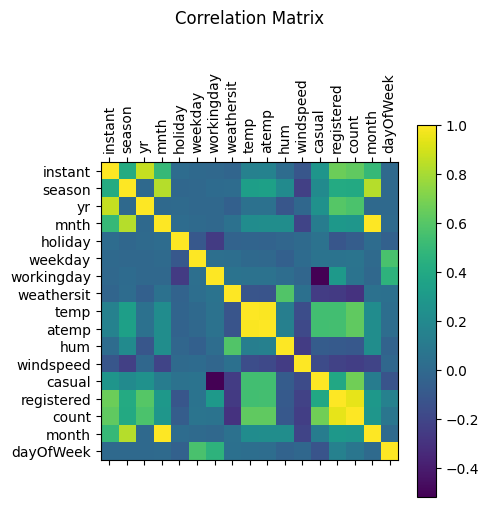

Training Score (Linear Regression): 0.7958922558627887
Test Score (Linear Regression): 0.7994249797892888
Training Score (Gradient Boosting): 0.9997104962823893
Test Score (Gradient Boosting): 0.8796492118250165


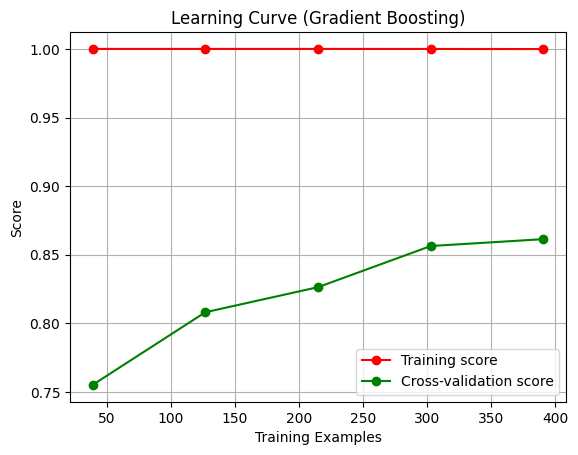

Training Score (SVR): 0.5417078557382842
Test Score (SVR): 0.5223736799712355
Training Score (Random Forest): 0.9816483996736478
OOB Score (Random Forest): 0.8713316988819942


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import linear_model, ensemble, svm

# Load data
df = pd.read_csv("/content/day.csv")

# Rename 'cnt' to 'count' for consistency
df.rename(columns={"cnt": "count"}, inplace=True)

# Convert date and set as index
df['date'] = pd.to_datetime(df['dteday'], dayfirst=True)
df.set_index('date', inplace=True)

# Extract temporal info
df['month'] = df.index.month
df['dayOfWeek'] = df.index.weekday

# ----------------------------
# Average rentals by day of week
mean_per_day = df.groupby("dayOfWeek")["count"].mean()
plt.figure()
plt.plot(mean_per_day)
plt.title("Average Rentals by Day of Week")
plt.xlabel("Day of the Week (0=Monday)")
plt.ylabel("Number of Rentals")
plt.grid()
plt.show()

# ----------------------------
# Average rentals by month
mean_per_month = df.groupby("month")["count"].mean()
plt.figure()
plt.plot(mean_per_month)
plt.title("Bike Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Number of Rentals")
plt.grid()
plt.show()

# ----------------------------
# Average rentals by weather
weather_labels = {
    1: 'Clear / Few clouds',
    2: 'Mist / Scattered clouds',
    3: 'Light rain / snow',
    4: 'Heavy rain / snow'
}
weather_means = df.groupby("weathersit")["count"].mean()
plt.figure()
plt.bar([weather_labels[i] for i in weather_means.index], weather_means.values, color="skyblue")
plt.title("Average Rentals by Weather Condition")
plt.xticks(rotation=15)
plt.ylabel("Number of Rentals")
plt.show()

# ----------------------------
# Variations with meteorological variables
D = {
    'Wind > 13 km/h': df[df['windspeed'] > 0.3]['count'].mean(),
    'Wind <= 13 km/h': df[df['windspeed'] <= 0.3]['count'].mean(),
    'Temp < 24°C': df[df['atemp'] < 0.7]['count'].mean(),
    'Temp >= 24°C': df[df['atemp'] >= 0.7]['count'].mean(),
    'Humidity > 62%': df[df['hum'] > 0.62]['count'].mean(),
    'Humidity <= 62%': df[df['hum'] <= 0.62]['count'].mean()
}
od = collections.OrderedDict(sorted(D.items()))
plt.figure()
plt.bar(range(len(od)), od.values(), width=1/1.6, color="blue", align='center')
plt.xticks(range(len(od)), od.keys(), rotation=15)
plt.title("Rental Demand by Weather Variables")
plt.ylabel("Number of Rentals")
plt.grid()
plt.show()

# ----------------------------
# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
plt.matshow(numeric_df.corr())
plt.colorbar()
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns)
plt.title("Correlation Matrix", pad=100)
plt.show()

# ----------------------------
# Modeling
df1 = df.drop(['dteday', 'casual', 'registered', 'instant'], axis=1)
target = df1['count'].values
train = df1.drop('count', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size=0.33, random_state=42)

# ----------------------------
# Learning curve function
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    plt.grid()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Linear Regression
linreg = linear_model.LinearRegression()
linreg.fit(X_train, Y_train)
print("Training Score (Linear Regression):", linreg.score(X_train, Y_train))
print("Test Score (Linear Regression):", linreg.score(X_test, Y_test))

# Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train, Y_train)
print("Training Score (Gradient Boosting):", gbr.score(X_train, Y_train))
print("Test Score (Gradient Boosting):", gbr.score(X_test, Y_test))
plot_learning_curve(gbr, "Learning Curve (Gradient Boosting)", X_train, Y_train)
plt.show()

# SVR
svr = svm.SVR(kernel='linear')
svr.fit(X_train, Y_train)
print("Training Score (SVR):", svr.score(X_train, Y_train))
print("Test Score (SVR):", svr.score(X_test, Y_test))

# Random Forest
rf = ensemble.RandomForestRegressor(n_estimators=30, oob_score=True, bootstrap=True)
rf.fit(train, target)
print("Training Score (Random Forest):", rf.score(train, target))
print("OOB Score (Random Forest):", rf.oob_score_)
